## 2. Sliding Window Algorithm

In [1]:
setwd("/Users/jacobbradley/Documents/CCG/Code")

### Packages

In [3]:
install.packages("tidyverse")
library(tidyverse)
# Data Handling

if (!requireNamespace("BiocManager"))
    install.packages("BiocManager")
BiocManager::install()
library(BiocManager)
# General bioinformatics packages

library(BSgenome)
library(BSgenome.Hsapiens.UCSC.hg19)
# Human genome build GChr37


The downloaded binary packages are in
	/var/folders/g9/9x6m35fn5ydf88vdlm9n1vg80000gn/T//RtmpQ7odVE/downloaded_packages


Bioconductor version 3.8 (BiocManager 1.30.3), R 3.5.1 (2018-07-02)
Update old packages: 'BiocManager', 'circlize', 'ELMER', 'ensembldb', 'farver',
  'foreign', 'ggpubr', 'Gviz', 'haven', 'lattice', 'MASS', 'Matrix', 'mclust',
  'mgcv', 'openssl', 'RcppEigen', 'readr', 'rtracklayer', 'survival',
  'VariantAnnotation'


In [4]:
source("TMB_Funcs.txt")
# My Stuff!

### Functions from TMB calculator

In [11]:
abridge <- function(maf_file, nonsilent = TRUE) {
# Takes a maf file and selects the characteristics required to perform TMB analysis
# and removes duplicate entries (which exist for a variety of reasons, consult
# the TCGA website)
# Requires tidyverse
    
    data_abridged <- maf_file %>% 
       select('Hugo_Symbol', Chromosome, one_of(c('Start_Position','Start_position')), one_of(c('End_Position','End_position')), Strand, Variant_Classification, Variant_Type, Reference_Allele, Tumor_Seq_Allele1, Tumor_Seq_Allele2, Tumor_Sample_Barcode,  Score) %>% 
        distinct()

    if (nonsilent == TRUE) {
        data_abridged <- data_abridged %>% 
            filter(Variant_Classification %in% c('Frame_Shift_Del', 'Frame_Shift_Ins', 'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation', 'Nonsense_Mutation', 'Nonstop_Mutation', 'Splice_Site', 'Translation_Start_Site'))
              }
    return(data_abridged)
}

In [12]:
TMB_Calc <- function(maf_file, nonsilent = TRUE) {
# Takes a maf file and outputs a table with tumor sample barcode and TMB value
# Requires tidyverse to be installed
# Depends on previous function 'abridge()'
    
    tmb_table <-  maf_file %>%  
                abridge(nonsilent = nonsilent) %>% 
                group_by(Tumor_Sample_Barcode) %>% 
                summarise(TMB = n()/30)
    
    return(tmb_table)
}

### New functions

In [13]:
Local_TMB_Calc <- function(maf_file, Chrom, Start, Window_Size, ns = FALSE, pre_abridged = FALSE) {
# takes a maf file and outputs a table with tumor sample barcode and local TMB 
# value for the window specified via chromosome, start position and window size
# requires tidyverse to be installed
# requires function 'abridge()'
    
    all_samples <- tibble(Tumor_Sample_Barcode = unique(maf_file$Tumor_Sample_Barcode))
    
    if (pre_abridged == FALSE) {
        maf_file <- abridge(maf_file, nonsilent = ns)
    }
    
    local_tmb_table  <- maf_file %>% 
        filter(Chromosome == Chrom) %>% 
        filter(Start_Position %in% (Start + 0:(Window_Size-1))) %>% 
        group_by(Tumor_Sample_Barcode) %>% 
        summarise(Local_TMB = n())
    
    local_tmb_table <- full_join(all_samples, local_tmb_table, by = "Tumor_Sample_Barcode")
    local_tmb_table[is.na(local_tmb_table)] <- 0
    
    return(local_tmb_table)
}

In [14]:
getSignificance <- function(local_tmb_table, global_tmb_table) {
# Takes a local tmb table and a global tmb table and returns the significance of their correlation
# Not currently set up to account for multiple testing
# Requires tidyverse
    
    comparison_table <- inner_join(local_tmb_table, global_tmb_table,
           by = "Tumor_Sample_Barcode") 
    #creates a table with Tumor sample barcode, global burden and local burden
    
    if (sum(comparison_table$Local_TMB != 0) > 0) {
    return(-log(summary(lm(TMB~Local_TMB, comparison_table))$coefficients[2,4]))
        }
    else {
        return(0)
    }
}
    

In [23]:
chromosome_slide <- function(maf_file, global_tmb_table = NULL, Chromosome, window_size, jump_length, ns = FALSE) {
# performs a sliding window algorithm on one chromosome
# outputs a vector of significances
# can be given a global tmb table, otherwise will calculate itself
# requires a genome to be loaded under name 'genome', ideally GChr37
# requires packages tidyverse, BSGenome and functions abridge, TMB_Calc, Local_TMB_Calc and getSignificance 
    
# NOTE there's a weird thing going on at the moment where "global_tmb_table = NULL" must be explicitly fed 
# to the function, else it doesn't work
    
    chromosomes <- c(1:22, "X", "Y")
    maf_file <- abridge(maf_file, nonsilent = ns)
    
    
    if (is.null(global_tmb_table)) {
        global_tmb_table <- TMB_Calc(maf_file, nonsilent = TRUE)
    }
    
    significance_vector <- c()
    position_vector <- c()
    chromosome_length <- length(genome[[which(chromosomes == Chromosome)]])
    
    
    for (position in seq(from = 1, to = chromosome_length - window_size, by = jump_length)) { 
        
        local_tmb_table <- Local_TMB_Calc(maf_file, Chrom = Chromosome, Start = position, Window_Size = window_size, pre_abridged = TRUE)
        significance_vector <- c(significance_vector, getSignificance(local_tmb_table, global_tmb_table))
        position_vector <- c(position_vector, position)
        
    
    } 
    
    len <- length(significance_vector)
    chromosome_vector <- rep(Chromosome, len)
    key_vector <- (1:len)/len
    
    return(tibble(chromosome = chromosome_vector, position = position_vector, key = key_vector, significance = significance_vector))
    
}

In [35]:
genome_slide <- function(maf_file, global_tmb_table = NULL, window_size, jump_length, ns = FALSE) {
   
    maf_file <- abridge(maf_file, nonsilent = ns)
    chromosomes <- c(1:22,"X","Y")
    
    if (is.null(global_tmb_table)) {
        global_tmb_table = TMB_Calc(maf_file, nonsilent = TRUE)
    }
    
    genome_association <- tibble(chromosome = character(), position = vector(), key = vector(), significance = vector())
    
    
    for (n in 1:24) {
        print(chromosomes[n])
        genome_association <- bind_rows(genome_association, chromosome_slide(maf_file, global_tmb_table, chromosomes[n], window_size, jump_length))   
    }
    
    return(genome_association)
    
}

### Attempt a very limited sliding window algorithm (1 Chromosome, 1 Data Set)

In [6]:
new_data <- read_tsv("/Volumes/CCG8/processed_data/brca_tcga/data_mutations_extended.txt")
genome <- BSgenome.Hsapiens.UCSC.hg19

#load a sample data set (in this case TCGA breast cancer data)
#load a reference genome to slide through

Warning message:
“Missing column names filled in: 'X54' [54]”Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  stop_WU = col_integer(),
  X54 = col_double(),
  tumor_vaf = col_double(),
  normal_ref_reads = col_integer(),
  start_WU = col_integer(),
  strand_WU = col_integer(),
  tumors_var_reads = col_integer(),
  normal_vaf = col_double(),
  tumor_ref_reads = col_integer(),
  normal_var_reads = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3282 parsing failures.
row # A tibble: 5 x 5 col     row col     expected  actual file                                         

In [8]:
window_size <- 1000000
jump_length <- 100000

In [10]:
x <- chromosome_slide(maf_file = new_data, global_tmb_table = NULL, Chromosome = "X", window_size, jump_length)

Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

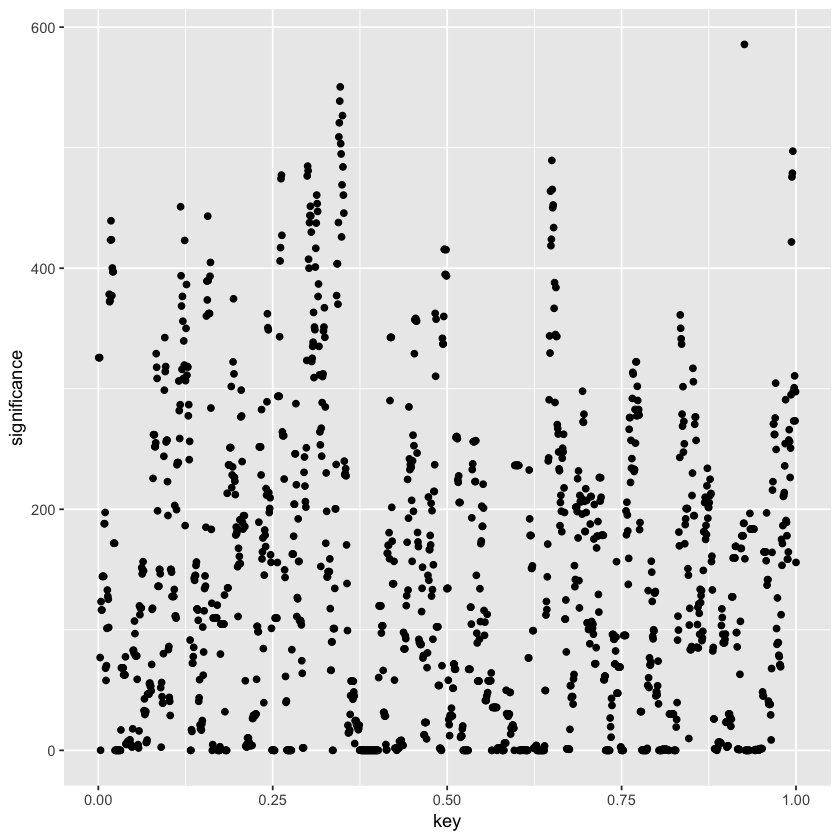

In [11]:
ggplot(x, aes(x= key, y = significance))+ geom_point()

### Do the same thing for the entire genome (1 Study)

In [185]:
window_size <- 1000000
jump_length <- 100000

genome_length <- 0
for (i in 1:24) {
    genome_length <- genome_length + length(genome[[i]])
}

In [244]:
gwas_first_run <- genome_slide(maf_file = new_data, global_tmb_table = NULL, window_size, jump_length)

In [14]:
#write_tsv(path = '/Users/jacobbradley/Documents/CCG/Data/gwas_first_run', x = gwas_first_run)

gwas_first_run <- read_tsv('/Users/jacobbradley/Documents/CCG/Data/gwas_first_run')

Parsed with column specification:
cols(
  chromosome = col_integer(),
  significance = col_double(),
  key = col_double()
)


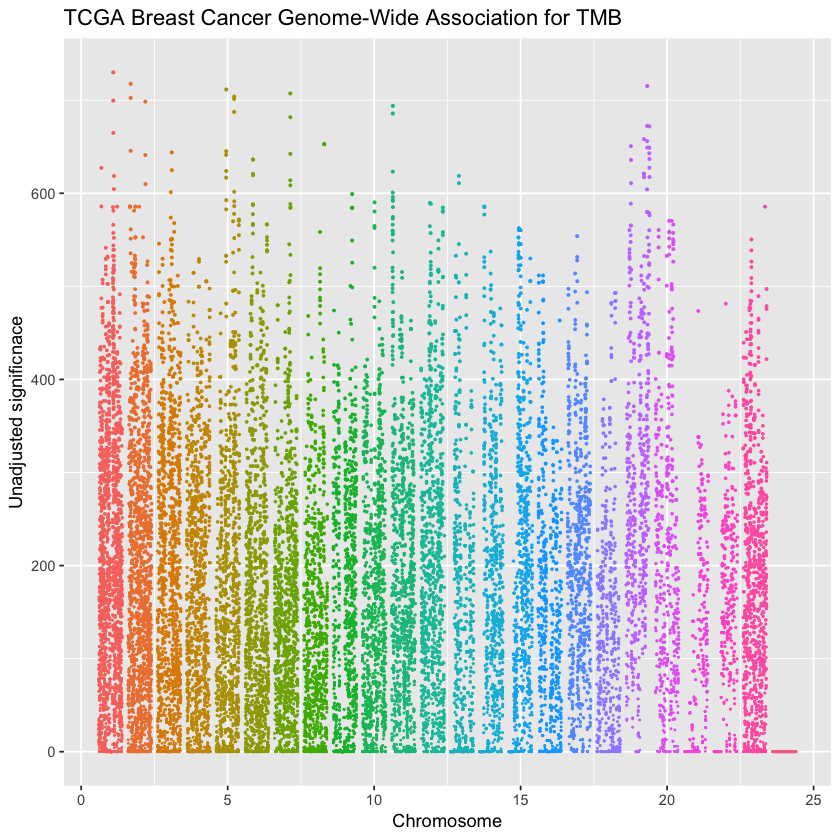

In [15]:
ggplot(gwas_first_run, aes(x = chromosome - 0.4 + 0.8*key, y = significance, colour = factor(chromosome), size = significance)) + 
    geom_point() + scale_size(range = c(0.1,0.5)) + theme(legend.position = "none") + labs(x = "Chromosome", y = "Unadjusted significnace") + 
    ggtitle("TCGA Breast Cancer Genome-Wide Association for TMB")


### Siphoning off the top 1% of positions

In [16]:
colnames(gwas_first_run)

[1] "chromosome"   "significance" "key"

In [34]:
quantile(gwas_first_run$significance, .99)

99% 
517.2948

In [38]:
dim(gwas_first_run[gwas_first_run$significance > quantile(gwas_first_run$significance, .99),])

[1] 308   3

In [ ]:
chromosomes <- c(1:22,"X","Y")
for (n in 1:24) {
        print(chromosomes[n])
        
}